In [2]:
import sys
import numpy as np
import argparse
from math import *

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import geom
import sonalleve
import transducers
import PBHE_CUDA

import importlib

import matplotlib.image as image
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d 
import csv
import HookJeeves

import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

def plotTraj(vec,maxR_mm=10,dR_mm=4,z_mm=140):
    points,nt,numSon = ablation_utils.contstruct_circ_sonication_points(maxR_mm,dR_mm,z_mm,vec[0],vec[1],vec[2])
    plt.plot(points[:,0], points[:,1], '*-')
    return points


%matplotlib inline

In [7]:
#plt.rc('text',usetex=True)
plt.rc('font', family='sans-serif', size=20)

In [2]:
importlib.reload(ablation_utils)

NameError: name 'importlib' is not defined

In [148]:
importlib.reload(geom)

<module 'geom' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\geom.py'>

In [3]:
rho=1000
Cp=4100
c0=1540
f0=1.2e6
k0=f0*2*pi/c0
ktdiffusion=0.6

uxyz = sonalleve.get_sonalleve_xdc_vecs()
unvec = sonalleve.get_sonalleve_xdc_normals()
N = uxyz.shape[0]

In [4]:
dataType=np.float32

nt=30
nx=62; ny=62; nz=62;
T=np.zeros([nt,nx,ny,nz],dtype=dataType)
Tdot=np.zeros([nx,ny,nz],dtype=dataType)
kdiff=np.zeros([nx,ny,nz],dtype=dataType)
rhoCp=np.zeros([nx,ny,nz],dtype=dataType)

Rbase = np.zeros([nx,ny,nz],dtype=dataType)

CEM=np.zeros([nx,ny,nz],dtype=dataType)
CEM0=np.zeros_like(CEM)

xrp = 1e-2*np.linspace(-2.0,2.0, nx, dtype=dataType)
yrp = 1e-2*np.linspace(-2.0,2.0, ny, dtype=dataType)
zrp = 1e-2*np.linspace(11.0, 17.0, nz, dtype=dataType)
dx=xrp[1]-xrp[0]
dy=yrp[1]-yrp[0]
dz=zrp[1]-zrp[0]
dt=0.1

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]

res = np.array([dt,dx,dy,dz],dtype=dataType)

kdiff[:]=ktdiffusion
rhoCp[:]= rho*Cp

if dataType == np.float32:
    Tmesh = PBHE_CUDA.mesh4d_f()
    Tdotmesh = PBHE_CUDA.mesh34d_f();
    kmesh = PBHE_CUDA.mesh3d_f();
    rhoCpmesh = PBHE_CUDA.mesh3d_f();


    PBHE_CUDA.ShareMemoryMesh4_f(T, res, Tmesh)
    PBHE_CUDA.ShareMemoryMesh34_f(Tdot, res, Tdotmesh)
    PBHE_CUDA.ShareMemoryMesh3_f(kdiff, res[1:4], kmesh)
    PBHE_CUDA.ShareMemoryMesh3_f(rhoCp, res[1:4], rhoCpmesh)
else:
    Tmesh = PBHE_CUDA.mesh4d()
    Tdotmesh = PBHE_CUDA.mesh34d();
    kmesh = PBHE_CUDA.mesh3d();
    rhoCpmesh = PBHE_CUDA.mesh3d();

    PBHE_CUDA.ShareMemoryMesh4(T, res, Tmesh)
    PBHE_CUDA.ShareMemoryMesh34(Tdot, res, Tdotmesh)
    PBHE_CUDA.ShareMemoryMesh3(kdiff, res[1:4], kmesh)
    PBHE_CUDA.ShareMemoryMesh3(rhoCp, res[1:4], rhoCpmesh)
    

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

simPhysGrid = {'T':T,'Tdot':Tdot,'Tmesh':Tmesh,'Tdotmesh':Tdotmesh,'kmesh': kmesh, 'rhoCpmesh':rhoCpmesh, 'kt': kdiff, 'rhoCp': rhoCp}
simPhysGrid['dtxyz'] = res
simPhysGrid['c0']=c0
simPhysGrid['rho']=rho
simPhysGrid['k0']=k0
simPhysGrid['xrp']=xrp
simPhysGrid['yrp']=yrp
simPhysGrid['zrp']=zrp

zsliceMask = np.zeros([nx,ny,nz],dtype=bool)
axsliceMask = np.zeros([nx,ny,nz],dtype=bool)

yi=floor(ny/2)
zsliceMask[:,:,focplaneZpix]=True
axsliceMask[:,yi,:]=True


ROION=   geom.roiGen([[-0.0015,0.0, 0.14]], lambda x,y,z: geom.inEllipse(x,y,z, 0.008, 0.008,0.015),gxp,gyp,gzp)    
ROIEXTRA=geom.roiGen([[-0.0015,0., 0.14]], lambda x,y,z: geom.inEllipse(x,y,z,0.01,0.01,0.04),gxp,gyp,gzp )
ROIOFF = np.logical_and( ROIEXTRA, np.logical_not(ROION))

In [6]:
xcenter=-0.001
#ROION=   geom.roiGen([[-0.0015,0.0, 0.14]], lambda x,y,z: geom.inCuboidBounds(x,y,z, xw=-[0.005, 0.005]),gxp,gyp,gzp)    
ROION=   geom.inCuboidBounds(gxp - xcenter,gyp,gzp, xr=[-0.0075, 0.0075], yr=[-0.0075, 0.0075], zr=[0.125, 0.15])   
ROIEXTRA=geom.roiGen([[xcenter,0., 0.14]], lambda x,y,z: geom.inCuboid(x,y,z,0.01,0.01,0.04),gxp,gyp,gzp )
ROIOFF = np.logical_and( ROIEXTRA, np.logical_not(ROION))

In [7]:
PBHE_CUDA.ResetGPU()
PBHE_CUDA.Create_Global_GPU_Session32(*T.shape)

In [8]:
RSkeys = dict(subsampN=10, ROC=0.14, subsampDiam=0.0033, gpublocks=512)

pp0 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, np.ones([N])/N, xrp, yrp, zrp, **RSkeys)  
Ip0 = np.abs(pp0)**2 / (2.0*rho*c0)
Ispta0 = 1.0e7
powRenorm = (Ispta0/np.max(Ip0))

In [80]:
xx=np.arange(-0.01, 0.01,0.0001)
smallVolumeFocField = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, np.ones([N])/N, xx, xx, xx+0.14, **RSkeys)  
smallVolumeI0 = np.abs(smallVolumeFocField)**2 / (2.0*rho*c0)
#Ispta0 = 1.0e7
#powRenorm = (Ispta0/np.max(Ip0))
smallVolumeI0 = (1e7/np.max(smallVolumeI0))

In [86]:
z_mm=140.0
speed=0.6
dwell=9.25
wait=2.0
traj=[10.0, 4.0, z_mm, speed, dwell, wait]

Npass=1
passTime = ablation_utils.trajTotalTime(*tuple(traj)) + traj[-1]
totTime=Npass*passTime

(coords_mm,nturns,numson)=ablation_utils.contstruct_circ_sonication_points(*tuple(traj))

totNumSonications=int(sum(numson)*Npass)
numFieldsPreAlloc=totNumSonications

doRotation=True
angle = 2*pi/(Npass)
Rzn = geom.getRotZYZarray(angle,0,0)

PathRotMat=None



In [92]:
try:
    del I0precomputed, I1precomputed
except NameError:
   1

<h3>Pre-compute intensity at sonication points. <h4>Only needs to be re-evaluated if the trajectory changes

In [87]:
(t0edges, amplitudes0) = ablation_utils.trajectorySettings(traj, Npass=Npass, doRotation=doRotation,L1renorm=sqrt(powRenorm),k0=k0,uxyz=uxyz)

I0precomputed = np.zeros([numFieldsPreAlloc,nx,ny,nz],dtype=dataType)

for soni in range(0,totNumSonications):
    print('\r%d / %d' %(soni+1,totNumSonications), end=' ')
    P0 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, amplitudes0[2*soni], xrp, yrp, zrp, **RSkeys )
    I0precomputed[soni][:] = np.abs(P0)**2 / (2*rho*c0)

9 / 9 

In [88]:
d=0.004
M=3
pxyz,r = geom.ring(d,M)
(t1edges, amplitudes1) = ablation_utils.trajectorySettings(traj, Npass=Npass, doRotation=doRotation,L1renorm=sqrt(powRenorm),k0=k0,uxyz=uxyz, pxyz=pxyz )  

I1precomputed = np.zeros([numFieldsPreAlloc,nx,ny,nz],dtype=dataType)

for soni in range(0,totNumSonications):
    print('\r%d / %d' %(soni+1,totNumSonications), end=' ')
    P1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, amplitudes1[2*soni], xrp, yrp, zrp, **RSkeys )
    I1precomputed[soni][:] = np.abs(P1)**2 / (2*rho*c0)

9 / 9 

<h4> One static focus case

In [59]:
numFieldsPreAlloc=1
totNumSonications=1

tstart=7.0
onTime = 30.0
postSonicaitionWait=5.0
totTime = onTime+ postSonicaitionWait+tstart

tStaticEdges=np.array( [ tstart, onTime+tstart, totTime ])

IStaticPrecomputed = np.zeros([numFieldsPreAlloc,nx,ny,nz],dtype=dataType)

ampstatic = sqrt(powRenorm)*np.ones([N])/N
ppStatic = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, ampstatic, xrp, yrp, zrp, **RSkeys)  
IStaticPrecomputed[0][:] = np.abs(ppStatic)**2 / (2*rho*c0)


In [119]:
extZX

array([ 11.,  17.,   2.,  -2.], dtype=float32)

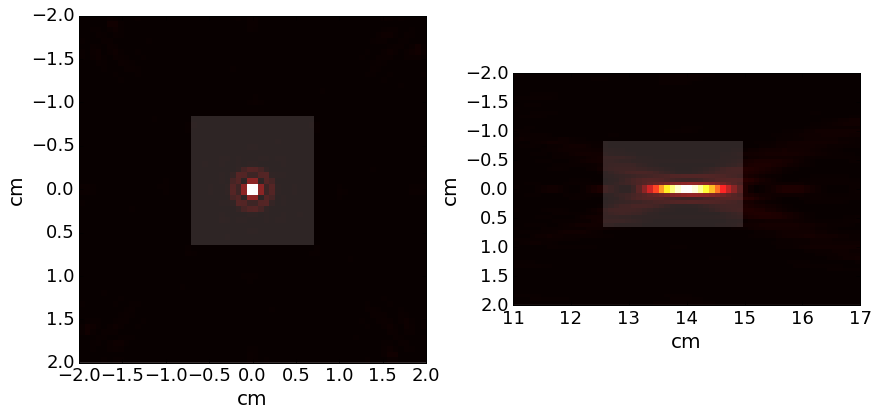

In [14]:
yi=floor( ny / 2 )
extXY = 100*np.array( [yrp[0],yrp[-1],xrp[-1],xrp[0]] )
extZX = 100*np.array( [zrp[0],zrp[-1],xrp[-1],xrp[0]] )

fig,axTable=plt.subplots(nrows=1,ncols=2,sharey=False,sharex=False, squeeze=True,gridspec_kw=dict(wspace=0.25,hspace=0.1), figsize=(14,8))
#fig=plt.figure(figsize=(8,8))

#sumIntensity = np.mean( I1precomputed, axis=0)
sumIntensity = np.mean( IStaticPrecomputed, axis=0)

ax=axTable[0]
im=ax.imshow(sumIntensity[:,:,focplaneZpix],cmap=image.cm.hot,interpolation='none', extent=extXY)
ax.imshow( ROION[:,:,focplaneZpix] , extent=extXY, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
#ax.plot(coords[:,1] /10,coords[:,0]/10,'--o')
ax.set_ylabel('cm', fontsize=20)


ax=axTable[1]
imT=ax.imshow( sumIntensity[:,yi,:], cmap=image.cm.hot,interpolation='none', extent=extZX)
ax.imshow( ROION[:,yi,:] , vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none',  extent=extZX)
ax.set_ylabel('cm', fontsize=20)


for ax in axTable.flatten():
    ax.set_xlabel('cm', fontsize=20)
    ax.tick_params(labelsize=18)

<h3> Heating simulation

In [12]:
T0=22.0

In [164]:
(t1edges, amplitudes1) = ablation_utils.trajectorySettings(traj, Npass=Npass, doRotation=doRotation,L1renorm=sqrt(powRenorm),k0=k0,uxyz=uxyz, pxyz=pxyz )  

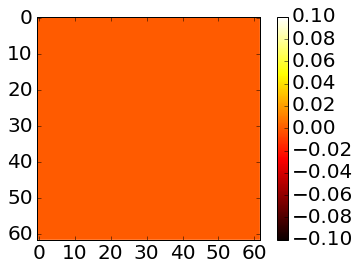

In [16]:
plt.imshow(T[0][:,:,focplaneZpix], interpolation='none', cmap=image.cm.hot )
plt.colorbar()

In [179]:

#create some dummy data
#dataX = interpTimes.copy()
#dataY = interpTemp.copy()

In [207]:
totTime=102

In [47]:
#load some sonalleve data

file="C:\\Users\\Vandiver\\Data\\sonalleve\\BatchAnalysis\\curves\\9-24-15_egg1_scan18_maxT.txt"

file="C:\\Users\\Vandiver\\Data\\sonalleve\\BatchAnalysis\\curves\\scan"
file="C:/Users/Vandiver/Data/sonalleve/BatchAnalysis/curves/scan10_TempTrans_20160223.PAR.txt"

#file="C:\\Users\\Vandiver\\Data\\sonalleve\\BatchAnalysis\\curves\\60W_multi_G1_2015-09-24_A_single.txt"
#file="C:\\Users\\Vandiver\\Data\\sonalleve\\BatchAnalysis\\curves\\40W_single_QA_2015-09-15_A_single.txt"

#file="C:\\Users\\Vandiver\\Data\\sonalleve\\BatchAnalysis\\curves\\60W_multi_QA_2015-09-26_A_single.txt"
#file="C:\\Users\\Vandiver\\Data\\sonalleve\\BatchAnalysis\\curves\\60W_multi_QA_2015-09-26_A_multi.txt"

#file="C:\\Users\\Vandiver\\Data\\sonalleve\\BatchAnalysis\\curves\\40W_multi_2015-09-26_A_single.txt"

mriTempData=np.genfromtxt(file,delimiter='\t')

dataX = mriTempData[:,0] 
dataY = mriTempData[:,1]

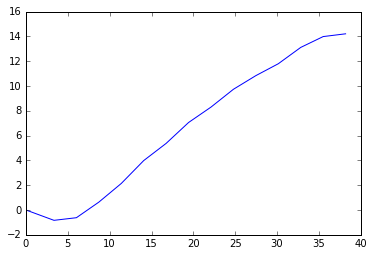

In [48]:
plt.plot(dataX, dataY)

In [379]:
objTimes<=totTime

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False], dtype=bool)

In [559]:
plt.rc('text', usetex=True)

In [60]:

#objTimes=np.arange(0,t1edges[-1],1.0)
objTimes=dataX
objTemp=np.zeros_like(objTimes)
objPBdict = dict(Freeflow=1, interpTimes=objTimes, interpolatedTemp=objTemp, interpFunc=np.mean, interpmask=ROION, perfRate=0.0)

timeSelectionMask = np.logical_and( objTimes<=totTime, objTimes >= 0.0 )

#timeEdges = t0edges
#intensitySet = I0precomputed

timeEdges = tStaticEdges
intensitySet = IStaticPrecomputed
kdiff[:]=ktdiffusion

def sim_objective(vec,T0=T0):

    alpha=vec[0]
    T[0] = T0
    CEM[:]=0
    objTemp[:]=T0

    numSons = intensitySet.shape[0]
    
    for soni in range(0,numSons):
        print('\r%d / %d' %(soni+1,numSons), end=' ')
        duration = timeEdges[2*soni + 1] - timeEdges[2*soni]
        Tdot[:] = dataType(2.0*alpha*intensitySet[soni] / rhoCp)
        ablation_utils.calc_heating(simPhysGrid, T, Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, duration, CEM, Rbase, GPU=True, interpoffset=timeEdges[2*soni], **objPBdict)

        Tdot[:] = 0
        duration = timeEdges[2*soni + 2] - timeEdges[2*soni+1]
        ablation_utils.calc_heating(simPhysGrid, T, Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, duration, CEM, Rbase, GPU=True, interpoffset=timeEdges[2*soni + 1], **objPBdict)

    
    #modelInterp = interp1d(objTimes, interpTemp, fill_value=0.0, bounds_error=False)
    value = np.sum((objTemp[timeSelectionMask]-T0 - dataY[timeSelectionMask])**2)
    print("Alpha = %2.3f  -> %f" % (alpha,value) )
    return value
    

def sim_objective2(vec,T0=T0):

    T[0] = T0
    CEM[:]=0
    objTemp[:]=T0
    alpha=vec[0]
    kdiff[:]=vec[1]

    numSons = intensitySet.shape[0]
    
    for soni in range(0,numSons):
        print('\r%d / %d' %(soni+1,numSons), end=' ')
        duration = timeEdges[2*soni + 1] - timeEdges[2*soni]
        Tdot[:] = dataType(2.0*alpha*intensitySet[soni] / rhoCp)
        ablation_utils.calc_heating(simPhysGrid, T, Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, duration, CEM, Rbase, GPU=True, interpoffset=timeEdges[2*soni], **objPBdict)

        Tdot[:] = 0
        duration = timeEdges[2*soni + 2] - timeEdges[2*soni+1]
        ablation_utils.calc_heating(simPhysGrid, T, Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, duration, CEM, Rbase, GPU=True, interpoffset=timeEdges[2*soni + 1], **objPBdict)

    
    #modelInterp = interp1d(objTimes, interpTemp, fill_value=0.0, bounds_error=False)
    value = np.sum((objTemp[timeSelectionMask]-T0 - dataY[timeSelectionMask])**2)
    print("Alpha = %2.3f, kt = %1.3f  -> %f" % (alpha,vec[1],value) )
    return value
    

In [63]:
hjEvalDict = HookJeeves.make_default_evaldict()
hjret=HookJeeves.minimize(sim_objective, np.array([6.5, 0.6]), np.array([0.5,0.2]), 2.0, [0.025,0.025], evaldict=hjEvalDict,T0=T0 )

#RESTART  0


  CEM[:] += (dt/60.0)*np.sum( Rbase**(T[0:buffsize]-43), 0  )



1 / 1 Alpha = 6.500  -> 12.701923
explore{0}
1 / 1 Alpha = 7.000  -> 4.311554
 #retain upward
explore{1}
1 / 1 Alpha = 7.000  -> 4.311554
1 / 1 Alpha = 7.000  -> 4.311554
  #discard
#PATTERN MOVE  0
1 / 1 Alpha = 7.500  -> 6.564201
explore{0}
1 / 1 Alpha = 8.000  -> 19.459846
 #retain downward
explore{1}
  #discard
[ 6.5  0.6] [ 7.   0.6] [ 7.   0.6]  :  None 4.31155420841 4.31155420841 False
#PATTERN MOVE  1
explore{0}
  #discard
explore{1}
  #discard
[ 7.   0.6] [ 7.   0.6] [ 7.   0.6]  :  4.31155420841 4.31155420841 4.31155420841 True
#PATTERN MOVE  2
explore{0}
  #discard
explore{1}
  #discard
[ 7.   0.6] [ 7.   0.6] [ 7.   0.6]  :  4.31155420841 4.31155420841 4.31155420841 True
#PATTERN MOVE  3
explore{0}
  #discard
explore{1}
  #discard
[ 7.   0.6] [ 7.   0.6] [ 7.   0.6]  :  4.31155420841 4.31155420841 4.31155420841 True
#PATTERN MOVE  4
explore{0}
  #discard
explore{1}
  #discard
[ 7.   0.6] [ 7.   0.6] [ 7.   0.6]  :  4.31155420841 4.31155420841 4.31155420841 True
#PATTERN MOV

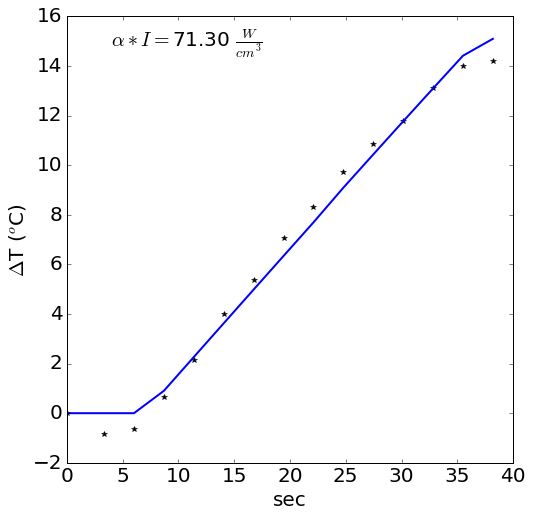

In [65]:
alphaIvalue=71.3
plt.figure(figsize=(8,8))
plt.plot(dataX,dataY, 'k*',linewidth=2.0)
plt.plot(objTimes[timeSelectionMask] ,objTemp[timeSelectionMask]-T0,'-',linewidth=2.0)
ax=plt.gca()
ax.set_xlabel('sec',fontsize=20)
ax.set_ylabel(r'$\Delta$T ($^o$C)',fontsize=20)
ax.tick_params(labelsize=20)
plt.text(0.1, 0.93, r'$\alpha*I = $%0.2f $\frac{W}{cm^3}$ '% alphaIvalue,transform=ax.transAxes, fontsize=20)

In [52]:
hjret

(array([ 6.125,  0.6  ]), 0)

In [61]:
sim_objective([6.125],T0=T0)

  CEM[:] += (dt/60.0)*np.sum( Rbase**(T[0:buffsize]-43), 0  )



1 / 1 Alpha = 6.125  -> 25.979134


25.979133872175563

In [235]:
hjEvalDict

{'InList': [array([ 3.5,  0.6]),
  array([ 4. ,  0.6]),
  array([ 3. ,  0.6]),
  array([ 3.5,  0.7]),
  array([ 3.5,  0.5]),
  array([ 3.75,  0.6 ]),
  array([ 3.75,  0.65]),
  array([ 3.75,  0.55]),
  array([ 4.5,  0.6]),
  array([ 4.25,  0.6 ]),
  array([ 3.25,  0.6 ]),
  array([ 3.75,  0.7 ]),
  array([ 3.75,  0.5 ])],
 'KeyEqualFunc': <function HookJeeves.defaultKeyEqual>,
 'ResultList': [23.46509749818664,
  50.966705132456056,
  198.65031984018489,
  23.46509749818664,
  23.46509749818664,
  11.880084346036057,
  11.880084346036057,
  11.880084346036057,
  281.15530528628688,
  140.72510455547467,
  85.721894062284619,
  11.880084346036057,
  11.880084346036057]}

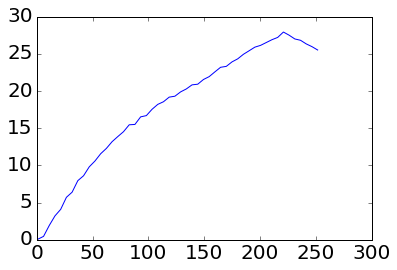

In [82]:
plt.plot(mriTempData[:,0], mriTempData[:,1])

In [405]:
dx*dy*dz*np.sum(ROION)*1e-6

1.9509647219084768e-11

In [535]:
importlib.reload(HookJeeves)

<module 'HookJeeves' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\HookJeeves.py'>

In [466]:
Tdot[:] = dataType(2.0*9.0*I0precomputed[soni] / rhoCp)

In [479]:
tp=np.arange(0.0, 10.0, 1)
tTemp=np.zeros_like(tp)
PBdict = dict(Freeflow=1, interpTimes=tp, interpolatedTemp=tTemp, interpFunc=np.max, interpmask=ROION, perfRate=0.0)
T[0][:] = 25
Tdot[:] = 0
Tdot[31,31,focplaneZpix] = 50.0
ablation_utils.calc_heating(simPhysGrid, T, Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, 10.0, CEM, Rbase, GPU=True, **PBdict)


(10.000000149011612, None, None, None)

In [81]:
plt.plot(tp,tTemp)

NameError: name 'tp' is not defined

In [478]:
tTemp

array([ 25.        ,  35.57712936,  38.40877533,  39.52275467,
        40.22099304,  40.66371536,  40.94628143,  41.18307114,
        41.36691284,  41.50113678])

In [509]:
0.5+np.random.randn()

-0.395168723327439

In [531]:
np.random.randint(0,high=5,size=x0.shape)/4.0

array([ 0.75,  0.5 ])

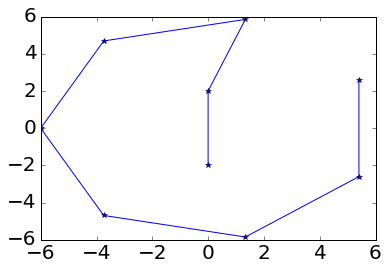

In [85]:
plotTraj([0.6,9.25,0]);